# **ASHRAE-Great Energy Predictor III**

### Mount The Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model
from keras.losses import mean_squared_error as mse_loss

from keras import optimizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc

### Load The data

In [ ]:
train_df = pd.read_feather('/gdrive/My Drive/case_study_data/train_df_dash.ftr')
test_df = pd.read_feather('/gdrive/My Drive/case_study_data/test_df_dash.ftr')

In [ ]:
train_df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,dayofweek,month,dayofyear,day,year,latitude,solarHour,solarDec,horizsolar,is_holiday,relative_humidity,sqaure_footage
0,46,0,3.994141,0,11,9.109375,3.912109,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.53125,-180.0,-23.03125,0.0,0,73.8125,35.62500
1,74,0,3.785156,0,8,12.867188,3.912109,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.53125,-180.0,-23.03125,0.0,0,73.8125,50.34375
2,93,0,3.978516,0,6,10.414062,3.912109,25.000000,6.0,20.000000,-0.17395,0.0,4.0,1.0,1.0,1.0,2016.0,28.53125,-180.0,-23.03125,0.0,0,73.8125,40.75000
3,105,0,3.191406,1,0,10.835938,3.912109,3.800781,0.0,2.400391,0.00000,0.0,4.0,1.0,1.0,1.0,2016.0,50.90625,-180.0,-23.03125,0.0,0,90.5000,42.40625
4,106,0,0.318115,1,0,8.585938,3.912109,3.800781,0.0,2.400391,0.00000,0.0,4.0,1.0,1.0,1.0,2016.0,50.90625,-180.0,-23.03125,0.0,0,90.5000,33.59375


In [ ]:
test_df.head()

,row_id,building_id,meter,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,dayofweek,month,dayofyear,day,year,latitude,solarHour,solarDec,horizsolar,is_holiday,relative_humidity,sqaure_footage
0,0,0,0,0,0,8.914062,3.849609,17.796875,4.000000,11.703125,0.282715,0.0,6.0,1.0,1.0,1.0,2017.0,28.53125,-180.0,-23.03125,0.0,0,67.50,34.31250
1,41614356,1393,0,15,1,11.929688,3.849609,-6.480469,2.132812,-11.085938,-1.000000,0.0,6.0,1.0,1.0,1.0,2017.0,40.71875,-180.0,-23.03125,0.0,0,69.75,45.93750
2,41614355,1392,2,15,1,11.242188,3.849609,-6.480469,2.132812,-11.085938,-1.000000,0.0,6.0,1.0,1.0,1.0,2017.0,40.71875,-180.0,-23.03125,0.0,0,69.75,43.28125
3,41614354,1392,0,15,1,11.242188,3.849609,-6.480469,2.132812,-11.085938,-1.000000,0.0,6.0,1.0,1.0,1.0,2017.0,40.71875,-180.0,-23.03125,0.0,0,69.75,43.28125
4,41614353,1391,2,15,1,11.140625,3.849609,-6.480469,2.132812,-11.085938,-1.000000,0.0,6.0,1.0,1.0,1.0,2017.0,40.71875,-180.0,-23.03125,0.0,0,69.75,42.87500


In [ ]:
train_df.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'hour', 'dayofweek', 'month',
       'dayofyear', 'day', 'year', 'latitude', 'solarHour', 'solarDec',
       'horizsolar', 'is_holiday', 'relative_humidity', 'sqaure_footage'],
      dtype='object')

In [ ]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            meancol = df[col].mean()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(meancol,inplace=True)  
                
                print('change for', meancol)
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [ ]:
#https://www.kaggle.com/tunguz/ashrae-histgradientboosting
categorical_features = ["building_id",
     "site_id",
     "meter",
     "primary_use",
     "hour",
     'dayofweek']
numerical_features = ["square_feet", "sqaure_footage", "air_temperature", "cloud_coverage",
              "dew_temperature", "precip_depth_1_hr", "floor_count", 'relative_humidity']

feature_column = categorical_features+numerical_features

In [ ]:
y = train_df.meter_reading
X = train_df.drop("meter_reading", axis=1)

In [ ]:
X, NAlist = reduce_mem_usage(X)

Memory usage of properties dataframe is : 733.977855682373  MB
******************************
Column:  building_id
dtype before:  int16
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int8
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  site_id
dtype before:  int8
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int8
min for this col:  0
max for this col:  15
dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  float16
min for this col:  5.65
max for this col:  13.68
dtype after:  float32
******************************
******************************
Column:  floor_count
dtype before:  float16
min for this col:  3.912
max

In [ ]:
def model(dense_dim_1=64, dense_dim_2=32, dense_dim_3=32, dense_dim_4=16, dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.001):
  #INPUTS
  site_id = Input(shape=[1], name="site_id")
  building_id = Input(shape=[1], name="building_id")
  meter = Input(shape=[1], name="meter")
  primary_use = Input(shape=[1], name="primary_use")
  square_feet = Input(shape=[1], name="square_feet")
  square_footage = Input(shape=[1], name="sqaure_footage")
  air_temperature = Input(shape=[1], name="air_temperature")
  cloud_coverage = Input(shape=[1], name="cloud_coverage")
  dew_temperature = Input(shape=[1], name="dew_temperature")
  hour = Input(shape=[1], name="hour")
  precip = Input(shape=[1], name="precip_depth_1_hr")
  dayofweek = Input(shape=[1], name="dayofweek")

  #Embeddings layers
  emb_site_id = Embedding(16, 2)(site_id)
  emb_building_id = Embedding(1449, 6)(building_id)
  emb_meter = Embedding(4, 2)(meter)
  emb_primary_use = Embedding(16, 2)(primary_use)
  emb_hour = Embedding(24, 3)(hour)
  emb_weekday = Embedding(7, 2)(dayofweek)

  concat_emb = concatenate([
           Flatten() (emb_site_id)
         , Flatten() (emb_building_id)
         , Flatten() (emb_meter)
         , Flatten() (emb_primary_use)
         , Flatten() (emb_hour)
         , Flatten() (emb_weekday)
    ])
  categ = Dropout(dropout1)(Dense(dense_dim_1,activation='relu') (concat_emb))
  categ = BatchNormalization()(categ)
  categ = Dropout(dropout2)(Dense(dense_dim_2,activation='relu') (categ))

  #main layer
  main_l = concatenate([
        categ
      , square_feet
      , square_footage
      , air_temperature
      , cloud_coverage
      , dew_temperature
      , precip
  ])
  main_l = Dropout(dropout3)(Dense(dense_dim_3,activation='relu') (main_l))
  main_l = BatchNormalization()(main_l)
  
  main_2 = concatenate([
        main_l
      , Flatten() (emb_building_id)
      , Flatten() (emb_site_id)

  ])
    
  main_2 = Dropout(dropout4)(Dense(dense_dim_4,activation='relu') (main_2))
  
  #output
  output = Dense(1) (main_2)

  model = Model([ site_id,
                  building_id, 
                  meter, 
                  primary_use, 
                  square_feet, 
                  square_footage, 
                  
                  air_temperature,
                  cloud_coverage,
                  dew_temperature, 
                  hour,
                  dayofweek, 
                  precip], output)

  model.compile(optimizer = Adam(lr=lr),
                loss= mse_loss,
                metrics=[root_mean_squared_error])
  return model

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0))


In [ ]:

def get_keras_data(df, num_cols, cat_cols):
    cols = cat_cols + num_cols
    X = {col: np.array(df[col]) for col in cols}
    return X

def train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold, patience=3):
    early_stopping = EarlyStopping(patience=patience, verbose=1)
    model_checkpoint = ModelCheckpoint("/gdrive/My Drive/case_study_data/model_" + str(fold) + ".hdf5",
                                       save_best_only=True, verbose=1, monitor='val_root_mean_squared_error', mode='min')

    hist = keras_model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(X_v, y_valid), verbose=1,
                            callbacks=[early_stopping, model_checkpoint])

    keras_model = load_model("/gdrive/My Drive/case_study_data/model_" + str(fold) + ".hdf5", custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    return keras_model

In [ ]:
#https://www.kaggle.com/tunguz/ashrae-histgradientboosting
from sklearn.model_selection import KFold, StratifiedKFold

oof = np.zeros(len(X))
batch_size = 256
epochs = 15
models = []

folds = 2
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=seed)

for fold_n, (train_index, valid_index) in enumerate(kf.split(X, X['building_id'])):
    print('Fold:', fold_n)
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    X_t = get_keras_data(X_train, numerical_features, categorical_features)
    X_v = get_keras_data(X_valid, numerical_features, categorical_features)
    
    keras_model = model(dense_dim_1=64, dense_dim_2=32, dense_dim_3=32, dense_dim_4=16, 
                        dropout1=0.2, dropout2=0.1, dropout3=0.1, dropout4=0.1, lr=0.001)
    mod = train_model(keras_model, X_t, y_train, batch_size, epochs, X_v, y_valid, fold_n, patience=3)
    models.append(mod)
    print('*'* 50)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold: 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: Input dict contained keys ['floor_count', 'relative_humidity'] which did not match any model input. They will be ignored by the model.
  return py_builtins.overload_of(f)(*args)


35791/35791 [==============================] - 331s 7ms/step - loss: 0.8929 - root_mean_squared_error: 0.8167 - val_loss: 0.3791 - val_root_mean_squared_error: 0.5985

Epoch 00001: val_root_mean_squared_error improved from inf to 0.59852, saving model to /gdrive/My Drive/case_study_data/model_0.hdf5
Epoch 2/15
35791/35791 [==============================] - 260s 7ms/step - loss: 0.3327 - root_mean_squared_error: 0.5735 - val_loss: 0.3601 - val_root_mean_squared_error: 0.5815

Epoch 00002: val_root_mean_squared_error improved from 0.59852 to 0.58153, saving model to /gdrive/My Drive/case_study_data/model_0.hdf5
Epoch 3/15
35791/35791 [==============================] - 239s 7ms/step - loss: 0.3211 - root_mean_squared_error: 0.5632 - val_loss: 0.3543 - val_root_mean_squared_error: 0.5766

Epoch 00003: val_root_mean_squared_error improved from 0.58153 to 0.57657, saving model to /gdrive/My Drive/case_study_data/model_0.hdf5
Epoch 4/15
35791/35791 [==============================] - 239s 7ms/

In [ ]:
test = test_df[feature_column]
test, NAlist = reduce_mem_usage(test)

Memory usage of properties dataframe is : 994.1483764648438  MB
******************************
Column:  building_id
dtype before:  int16
min for this col:  0
max for this col:  1448


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  uint16
******************************
******************************
Column:  site_id
dtype before:  int8
min for this col:  0
max for this col:  15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  uint8
******************************
******************************
Column:  meter
dtype before:  int8
min for this col:  0
max for this col:  3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  uint8
******************************
******************************
Column:  primary_use
dtype before:  int8
min for this col:  0
max for this col:  15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  uint8
******************************
******************************
Column:  hour
dtype before:  float16
min for this col:  0.0
max for this col:  23.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  uint8
******************************
******************************
Column:  dayofweek
dtype before:  float16
min for this col:  0.0
max for this col:  6.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  uint8
******************************
******************************
Column:  square_feet
dtype before:  float16
min for this col:  5.65
max for this col:  13.68


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  float32
******************************
******************************
Column:  sqaure_footage
dtype before:  float16
min for this col:  21.75
max for this col:  89.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  float32
******************************
******************************
Column:  air_temperature
dtype before:  float16
min for this col:  -28.1
max for this col:  48.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  float32
******************************
******************************
Column:  cloud_coverage
dtype before:  float16
min for this col:  0.0
max for this col:  9.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  float32
******************************
******************************
Column:  dew_temperature
dtype before:  float16
min for this col:  -31.6
max for this col:  26.7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  float32
******************************
******************************
Column:  precip_depth_1_hr
dtype before:  float16
min for this col:  -1.0
max for this col:  597.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  float32
******************************
******************************
Column:  floor_count
dtype before:  float16
min for this col:  3.85
max for this col:  6.527


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dtype after:  float32
******************************
******************************
Column:  relative_humidity
dtype before:  float16
min for this col:  2.117
max for this col:  156.2
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1550.8713989257812  MB
This is  155.9999931238257 % of the initial size


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#https://www.kaggle.com/tunguz/ashrae-histgradientboosting
i=0
res = np.zeros((test.shape[0]),dtype=np.float32)
step_size = 50000
for j in range(int(np.ceil(test.shape[0]/step_size))):
    print('iteration {} - count {}'.format(j,i))
    for_prediction = get_keras_data(test.iloc[i:i+step_size], numerical_features, categorical_features)
    res[i:min(i+step_size,test.shape[0])] = \
       np.expm1(sum([model.predict(for_prediction, batch_size=1024)[:,0] for model in models])/folds)
    i+=step_size

iteration 0 - count 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: Input dict contained keys ['floor_count', 'relative_humidity'] which did not match any model input. They will be ignored by the model.
  return py_builtins.overload_of(f)(*args)


iteration 1 - count 50000
iteration 2 - count 100000
iteration 3 - count 150000
iteration 4 - count 200000
iteration 5 - count 250000
iteration 6 - count 300000
iteration 7 - count 350000
iteration 8 - count 400000
iteration 9 - count 450000
iteration 10 - count 500000
iteration 11 - count 550000
iteration 12 - count 600000
iteration 13 - count 650000
iteration 14 - count 700000
iteration 15 - count 750000
iteration 16 - count 800000
iteration 17 - count 850000
iteration 18 - count 900000
iteration 19 - count 950000
iteration 20 - count 1000000
iteration 21 - count 1050000
iteration 22 - count 1100000
iteration 23 - count 1150000
iteration 24 - count 1200000
iteration 25 - count 1250000
iteration 26 - count 1300000
iteration 27 - count 1350000
iteration 28 - count 1400000
iteration 29 - count 1450000
iteration 30 - count 1500000
iteration 31 - count 1550000
iteration 32 - count 1600000
iteration 33 - count 1650000
iteration 34 - count 1700000
iteration 35 - count 1750000
iteration 36 -

In [ ]:

submission = pd.read_csv('/gdrive/My Drive/case_study_data/sample_submission.csv')
submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('/gdrive/My Drive/case_study_data/submission_dense_nn.csv', index=False)
submission

,row_id,meter_reading
0,0,212.389099
1,1,85.228004
2,2,3049.275879
3,3,86.337090
4,4,1400.786133
...,...,...
41697595,41697595,999.489929
41697596,41697596,675.216858
41697597,41697597,2380.202881
41697598,41697598,296.428894


### Refrences
1. https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
2. https://www.kaggle.com/tunguz/ashrae-histgradientboosting

In [2]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model", "RMSE"]
summary.add_row(["Demse NN",.57432])
print(summary)

+----------+---------+
|  Model   |   RMSE  |
+----------+---------+
| Demse NN | 0.57432 |
+----------+---------+


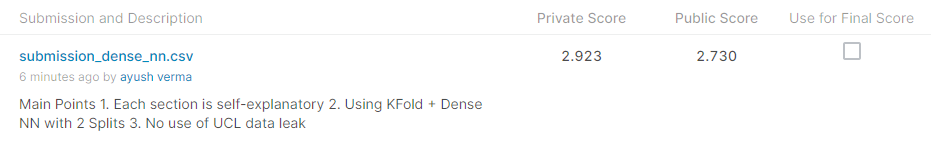

In [1]:
from IPython.display import Image
Image(filename='DENSE NN1.PNG')